This notebook is written in the language of Majorana operators following the convention of [BZ22]

In [ ]:
from quspin.operators import hamiltonian
from quspin.basis import spinless_fermion_basis_1d
from pyscf import gto, scf
import openfermion as of
import numpy as np
import scipy as sp
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.special import erf
from copy import deepcopy
from itertools import chain
import matplotlib.pyplot as plt
from utils.spatial2spin import spinorb_from_spatial_ovlp

In [92]:
# Define the molecule

mol = gto.M(
    atom='''
H 0 0 0
H 0 0 0.7
''',
    basis='sto3g', 
    #spin = 1,
    unit='angstrom'
)

# Perform Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()
print(f'N_ao = {mol.nao}')
print(f'N_ele = {mol.tot_electrons()}')
n_qubits = int(2 * mol.nao)
n_ele = int(mol.tot_electrons())
e_nuc = mol.energy_nuc()

converged SCF energy = -1.11734903499028
N_ao = 2
N_ele = 2


For HF method, we have:
$$
 (\ket{\psi_1},\cdots,\ket{\psi_{2L}}) = (\ket{\phi_1},\cdots,\ket{\phi_{2L}}) \Phi,
$$
The Fock operator:
$$
\hat{f}(r_i) = \hat{h}(r_i)+ \hat{V}(r_i)-\hat{K}(r_i),
$$
and calculation of the Fock matrix elements:
$$
F_{kl} = h_{kl}+V_{kl}-K_{kl},
$$
where the single electron integral term reads
$$ 
h_{kl} = \langle \phi_k|\hat{h}|\phi_l\rangle = (i|h|j).
$$
For the Fock potential terms, they depend on the molecular orbital coefficients $\Phi$. Formally, we have:
$$
\hat{V}[\Phi] \ket{\phi_l} = \sum_{j=1}^{2L}\langle \psi_j |r^{-1} |\psi_j\rangle \ket{\phi_l},
$$
$$
\hat{K}[\Phi]\ket{\phi_l} = \sum_{j=1}^{2L}\langle \psi_j | r^{-1}|\phi_l\rangle \ket{\psi_j}.
$$ 

Therefore we can calculate the matrix elements
$$
\begin{align*}
V_{kl}  &= \langle \phi_k |\hat{V}|\phi_l\rangle \\&=\sum_{pq} (\widetilde{\Phi}\widetilde \Phi^\dagger)_{p,q} \int \phi_k(1)\phi_p(2)r_{12}^{-1}\phi_l(1)\phi_q(2)\mathrm{d}1\mathrm{d}2\\
&=\sum_{pq} (\widetilde{\Phi}\widetilde \Phi^\dagger)_{p,q} r_{kplq}
\end{align*}
$$
$$
\begin{align*}
K_{kl}  &= \langle \phi_k |\hat{V}|\phi_l\rangle \\&=\sum_{pq} (\widetilde{\Phi}\widetilde \Phi^\dagger)_{p,q} \int \phi_k(1)\phi_p(2)r_{12}^{-1}\phi_q(1)\phi_l(2)\mathrm{d}1\mathrm{d}2\\
&=\sum_{pq} (\widetilde{\Phi}\widetilde \Phi^\dagger)_{p,q} r_{kpql}
\end{align*}
$$
Note that the coefficient matrix (density matrix) only considers the part related to the first $N$ particles.

In [93]:
##### define molecular Hamiltonians ###
def get_integrals(mol:gto.M):
    e1, ovlp, eri = mol.intor('int1e_nuc')+mol.intor('int1e_kin'), mol.intor('int1e_ovlp'), mol.intor('int2e')
    # read: (ij|kl) -> (ik|jl) = <ij|kl> (if the spin is right)
    eri = np.transpose(eri, (0,2,1,3)) 
    e1_spin, ovlp_spin, eri_spin = spinorb_from_spatial_ovlp(e1, ovlp, eri)
    return e1_spin, ovlp_spin, eri_spin

## compute the fock operators
# fock_kl = h_kl + V_kl - K_kl
def get_fock(rho, e1_spin, eri_spin):
    fock = e1_spin + np.einsum('pq, kplq', rho, eri_spin, optimize = True) - np.einsum('pq, kpql', rho, eri_spin, optimize = True)
    return(fock)

def get_energy(rho, e1_spin, eri_spin):
    return np.einsum('kl,kl',rho,e1_spin)\
             +0.5*np.einsum('kl,pq,kplq',rho,rho,eri_spin,optimize=True)\
             -0.5*np.einsum('kq,pl,kplq',rho,rho,eri_spin,optimize=True)

def get_first_order(rho, eri_spin):
    return -0.5*np.einsum('kl,pq,kplq',rho,rho,eri_spin,optimize=True)\
             +0.5*np.einsum('kq,pl,kplq',rho,rho,eri_spin,optimize=True)
    

e1_spin, ovlp_spin, eri_spin = get_integrals(mol)
## initialize coefficient matrix \Phi and density matrix \rho
Phi0 = np.zeros((n_qubits,n_qubits))
rho0 = np.dot(Phi0[:,:n_ele],Phi0[:,:n_ele].T)

SCF iteration



Let $\ket{\Psi}$ be the Slater determinant constructed using $(\ket{\psi_1},\cdots,\ket{\psi_N})$, then the HF energy will be (note that for any single Slater determinant, the SC rules also hold)
$$
E_{\mathrm{HF}} = \langle \Psi | \hat H| \Psi\rangle = \sum_a \langle\psi_a |h |\psi_a \rangle +\frac{1}{2}\sum_{ab}[\psi_a\psi_a|\psi_b\psi_b]-[\psi_a\psi_b|\psi_b\psi_a].
$$
Here, $[\cdot\cdot|\cdot\cdot]$ denotes the chemists' notation of double-electron integrals. We expand this expression into terms of electron integrals of atomic (basis) orbitals:
$$
E_{\mathrm{HF}} = \sum_k\sum_l(\widetilde\Phi\widetilde\Phi^\dagger)_{kl}h_{kl}+\frac{1}{2}\sum_{kplq}(\widetilde\Phi\widetilde\Phi^\dagger)_{kl}(\widetilde\Phi\widetilde\Phi^\dagger)_{pq}r_{kplq}-(\widetilde\Phi\widetilde\Phi^\dagger)_{kq}(\widetilde\Phi\widetilde\Phi^\dagger)_{pl}r_{kplq}
$$

In [94]:
## SCF iterations
def scf_iteration(e1_spin, eri_spin, verbose = False, Phi = Phi0, rho = rho0, TOL = 1e-15):
    last_energy = 0
    cycle = 0
    while True:
        cycle += 1
        fock = get_fock(rho, e1_spin, eri_spin)
        # solve FC = SCE, renew Phi
        e_val, Phi = eigh(fock,ovlp_spin)
        # calculate new density matrix
        rho = np.dot(Phi[:,:n_ele],Phi[:,:n_ele].T)
        # calculate energy
        energy = get_energy(rho, e1_spin, eri_spin)
        if verbose:
            print('{} iteration, ground energy = {:5f}'.format(cycle,energy+e_nuc))
        if np.abs(energy-last_energy)<TOL:
            print('Energy Converged.')
            if verbose:
                print('The converged HF energy is {:5f}'.format(energy+e_nuc))
            break
        else:
            last_energy = energy
    return energy+e_nuc, fock, rho

In [95]:
HF_energy, fock, rho = scf_iteration(e1_spin, eri_spin, verbose = True)

1 iteration, ground energy = -1.117349
2 iteration, ground energy = -1.117349
Energy Converged.
The converged HF energy is -1.117349


### Constructing the Converged HF Hamiltonian

To construct the converged Hartree-Fock (HF) Hamiltonian, we start by noting that the HF state is the ground state of the following Hamiltonian:
$$
\hat{H}_0 = \sum_{i=1}^N \hat{f}(r_i).
$$
Here, $\hat{f}(r_i)$ is the Fock operator for the $i$-th particle.

We now move to the second quantization framework, which avoids dealing directly with Slater determinants by using fermionic operators. In second quantization, we assume a set of orthonormal basis (spin orbitals) $\{\varphi_i\}_{i=1}^{2L}$. Using this basis, we construct the Fock space $\mathcal{F}$, or in our case, a sector of $\mathcal{F}$ with a specific particle number $\mathcal{F}_N$. In this setting, $\hat{H}_0$ becomes:
$$
\hat{H}_0 = \sum_{p,q=1}^{2L} F_{pq} a_p^\dagger a_q,
$$
where $F_{pq}$ are the matrix elements of the Fock operator within the orthonormal basis.

As we know, molecular orbitals $\{\psi_i\}_{i=1}^{2L}$ are commonly used orthonormal bases in quantum chemistry. We denote the fermionic operators as $\{c_p^\dagger, c_p\}_p$. Since the HF state is precisely the single Slater determinant constructed using the molecular orbitals, in second quantization, it is given by:
$$
\ket{\mathrm{HF}} = \prod_{i=1}^N c_i^\dagger \ket{\mathrm{vac}} = \ket{\underbrace{1\cdots 1}_{N}\underbrace{0\cdots0}_{2L-N}}.
$$
The Hamiltonian $\hat{H}_0$ in this basis takes the form:
$$
\hat{H}_0 = \sum_{k=1}^{2L} \varepsilon_k c_k^\dagger c_k,
$$
where $\varepsilon_k$ represents the $k$-th molecular orbital energy. Additionally, since $\ket{\mathrm{HF}} = \ket{\underbrace{1\cdots 1}_{N}\underbrace{0\cdots0}_{2L-N}}$, the Hamiltonian matrix $H$ in the fermionic basis of the $N$-particle sector gives the HF energy as $E_{\mathrm{HF}} = \langle \mathrm{HF}|\hat{H}|\mathrm{HF}\rangle = H_{00}$.

We can also directly construct the HF Hamiltonian using the converged Fock operator from the self-consistent field (SCF) process. However, we need to orthogonalize the basis set to facilitate the second-quantization representation. Given that the overlap matrix is Hermitian and non-singular, we can decompose it as:
$$
S = U s U^\dagger,
$$
where $U$ is a unitary matrix, and $s$ is a diagonal matrix of eigenvalues. We define the transformation matrix $X = U s^{-1/2}$ and transform the Fock operator accordingly:
$$
F \mapsto X^\dagger F X.
$$
This transformation is equivalent to using the orthogonalized (atomic) orbitals as the basis set. Thus, the HF state is the ground state of the quadratic Hamiltonian:
$$
\hat{H}_0 = \sum_{p,q=1}^{2L} F_{pq} a_p^\dagger a_q,
$$
(within the orthogonalized basis set), and the ground state energy is $\sum_{k=1}^N \varepsilon_k$.

### Remarks

1. The ground state of any quadratic Hamiltonian (or non-interacting Hamiltonian) $\sum_{p,q=1}^{2L} F_{pq} a_p^\dagger a_q$ is a single determinant. Diagonalizing $(F)_{pq}$ yields a unitary matrix $\Phi$ and eigenvalues $\varepsilon_k$. Implementing a basis rotation to the fermionic operators:
   $$
   c_k^\dagger = (a_1^\dagger, \cdots, a_{2L}^\dagger) \Phi, \quad c_k = (a_1, \cdots, a_{2L}) \overline{\Phi},
   $$
   transforms the Hamiltonian to:
   $$
   \hat{H}_0 = \sum_k \varepsilon_k c_k^\dagger c_k,
   $$
   and the ground state becomes $\prod_i^N c_i^\dagger \ket{\mathrm{vac}}$.

2. Generally, $\sum_{i=1}^N \varepsilon_k \neq E_{\mathrm{HF}}$. However, the correct HF energy can be retrieved by adding the first-order energy $E_1$ (defined previously in the program):
   $$
   E_{\mathrm{HF}} = \sum_{i=1}^N \varepsilon_k + E_1.
   $$


In [96]:
def get_quadratic_fock(fock): 
    # orthogonalize the atomic orbitals and write down the coefficient matrix of the quadratic Hamiltonian form of the converged Fock operator
    s, U = np.linalg.eigh(ovlp_spin)
    sqrt_sinv = np.diag(np.sqrt(np.reciprocal(s)))
    X = U @ sqrt_sinv
    fock_pr = X.T @ fock @ X
    return fock_pr

#sum_ei - 0.5*np.einsum('kl,pq,kplq',rho,rho,eri_spin,optimize=True)\
#             +0.5*np.einsum('kq,pl,kplq',rho,rho,eri_spin,optimize=True)+e_nuc


def get_fock_hamilitonian(fock_pr, rho):
    print("==== ready to construct the Fock Hamiltonian \sum_k F_pq a_p^dag a_q ====")
    # quspin setting
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

    ## converged HF hamiltonian
    Hfock = []
    for i in range(n_qubits):
        for j in range(n_qubits):
            if abs(fock_pr[i][j]) > 1e-15:
                Hfock.append([fock_pr[i][j], i, j]) # a_i^+ a_j, '+-'
    fermbas = spinless_fermion_basis_1d(n_qubits, Nf = n_ele) # restrict to the 2 sector
    H_fock = hamiltonian([['+-', Hfock]],[], basis=fermbas, dtype=np.float64,**no_checks)
    H_mat = np.array(H_fock.todense())
    print(f'This is a matrix with size binom(N_qubit, N_ele)= binom({n_qubits}, {n_ele}) = {H_mat.shape[0]}')
    e, evc = np.linalg.eigh(H_mat)
    print(f'The ground eigenvalue (\sum e_i) is {e[0]}')
    #HFGS = evc.T[0]

    HF_energy = e[0]  + get_first_order(rho, eri_spin) + e_nuc
    print(f'The HF energy is {HF_energy}')
    print('========')
    return H_mat, HF_energy

fock_pr = get_quadratic_fock(fock)
H_mat, HF_energy = get_fock_hamilitonian(fock_pr, rho)

e_orb = eigh(fock_pr)[0] 
print(f'list of single orbital energies : {e_orb}')

sum_ei = 0
occ = 0
for i in range(len(e_orb)):
    if e_orb[i] > 0:
        print(f'occ number = {occ}')
        print(f'sum_ei = {sum_ei}') # the summation of single orbital energy
        break
    else:
        occ += 1
        sum_ei += e_orb[i]


==== ready to construct the Fock Hamiltonian \sum_k F_pq a_p^dag a_q ====
This is a matrix with size binom(N_qubit, N_ele)= binom(4, 2) = 6
The ground eigenvalue (\sum e_i) is -1.1909269460096659
The HF energy is -1.1173490349902786
list of single orbital energies : [-0.59546347 -0.59546347  0.71416528  0.71416528]
occ number = 2
sum_ei = -1.1909269460096663


## Majorana Quadratic Hamiltonians

As mentioned in [Barthel2022], any quadratic (non-interacting) fermionic Hamiltonian (with Hermitian coefficient matrix) can be written in the form of quadratic Majorana Hamiltonian, whose coefficient matrix is both Hermitian and anti-symmetric:
$$
\hat{H} = \sum_{pq}^{2L} F_{pq} a_p^\dagger a_q = \sum_{ij}^{4L} H_{ij} \hat{w}_i \hat{w}_j,
$$
where:

+ The Majorana operators are defined as
    $$
    \begin{pmatrix}\hat{w}_{j,+}\\\hat{w}_{j,-}\end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1&1\\i&-i\end{pmatrix}\begin{pmatrix}\hat{a}_{j}\\\hat{a}_{j}^\dagger\end{pmatrix}\Leftrightarrow  \begin{pmatrix}\hat{a}_{j}\\\hat{a}_{j}^\dagger\end{pmatrix}= \frac{1}{\sqrt{2}}\begin{pmatrix}1&-i\\1&i\end{pmatrix}\begin{pmatrix}\hat{w}_{j,+}\\\hat{w}_{j,-}\end{pmatrix}
    $$
    And we simplify the notation by defining
    $$
    \hat{w}_j := \hat{w}_{j,+},\quad \hat{w}_{j+2L} :=  \hat{w}_{j,-}\quad \text{for} \quad j=1,2,\cdots,2L.
    $$
+ For the matrix $H = (H_{ij})_{4L\times 4L}$, we compute:
    $$
    \begin{align*}
    \hat{H} &= \sum_{p,q} F_{pq} a_p^\dagger a_q = \frac{1}{2}\sum_{p,q} F_{pq} a_p^\dagger a_q + \frac{1}{2}\sum_{p,q} F_{pq} (\delta_{pq}-a_qa_p^\dagger)\\
    &=\frac{1}{2} \sum_{p,q} F_{pq} a_p^\dagger a_q -\frac{1}{2} \sum_{p,q}(F^T)_{p,q} a_p a_q^\dagger + \frac{1}{2} \mathrm{Tr}F\cdot \mathbf{1}\\
    & = (a_1,\cdots, a_{2L},a_1^\dagger,\cdots, a_{2L}^\dagger )\begin{pmatrix}
    0& -\frac{F^T}{2}\\ \frac{F}{2} & 0\end{pmatrix} \begin{pmatrix}a_1\\\vdots \\ a_{2L}\\a_1^\dagger\\\vdots \\ a_{2L}^\dagger\end{pmatrix}+ \frac{1}{2} \mathrm{Tr}F\cdot \mathbf{1}\\
    & = \frac{1}{2}(\hat{w}_1,\cdots,\hat{w}_{4L} )\begin{pmatrix}I&I\\-iI&iI\end{pmatrix}\begin{pmatrix}
    0& -\frac{F^T}{2}\\ \frac{F}{2} & 0\end{pmatrix} \begin{pmatrix}I&-iI\\I&iI\end{pmatrix}\begin{pmatrix}\hat{w}_1\\\vdots\\\hat{w}_{4L}\end{pmatrix}
    + \frac{1}{2} \mathrm{Tr}F\cdot \mathbf{1}\\
    &=\frac{1}{2}(\hat{w}_1,\cdots,\hat{w}_{4L} )\begin{pmatrix}\frac{F-F^T}{2}&\frac{-i(F+F^T)}{2}\\ \frac{i(F+F^T)}{2}& \frac{F-F^T}{2}\end{pmatrix}\begin{pmatrix}\hat{w}_1\\\vdots\\\hat{w}_{4L}\end{pmatrix}+ \frac{1}{2} \mathrm{Tr}F\cdot \mathbf{1}\\
    & = \sum_{i,j}^{4L} H_{ij} \hat{w}_i\hat{w}_j+ \frac{1}{2} \mathrm{Tr}F\cdot \mathbf{1}
    \end{align*}
    $$
    
    Here $H_{ij}$ is Hermitian and anti-symmetric.

In [97]:
def get_majorana_coeff(fock_pr):
    block1 = 0.5j*(fock_pr + fock_pr.T)
    block2 = 0.5*(fock_pr - fock_pr.T)

    h = 0.5*np.block([[block2, -block1],[block1, block2]]) 
    return h

def get_majorana_hamiltonian(h):
    # input: majorana_coeff
    L = int(len(h[0])/2)

    fermopof = of.FermionOperator()

    ## constructing majoranas
    majoranas = [of.FermionOperator(((i,0)),1/np.sqrt(2))+of.FermionOperator(((i,1)),1/np.sqrt(2)) for i in range(L)]
    for i in range(L):
        majoranas.append(of.FermionOperator(((i,0)),1j/np.sqrt(2))+of.FermionOperator(((i,1)),-1j/np.sqrt(2)))
    ## constructing majoranas ends


    # construct the quadratic majorana hamiltonian using openfermion
    for i, row in enumerate(h):
        for j, value in enumerate(row):
            if abs(value) > 1e-10:
                fermopof += value*majoranas[i]*majoranas[j]
    hamiltonian_matrix_of = of.get_sparse_operator(fermopof)
    #print(eigsh(hamiltonian_matrix_of)[0]+0.5*np.trace(fock_pr))
    ground_energy = min(eigsh(hamiltonian_matrix_of)[0])
    #print(ground_energy)
    return hamiltonian_matrix_of, ground_energy
    
h = get_majorana_coeff(fock_pr)
hamiltonian_matrix_of, ground_energy = get_majorana_hamiltonian(h)
gap = np.sort(eigsh(hamiltonian_matrix_of)[0])[1] - np.sort(eigsh(hamiltonian_matrix_of)[0])[0] 


In [98]:
# ideal filter

filter_a = 1e17
filter_b = 1e-17
filter_da = 0.1
filter_db = 1e-17

# practical filter (that depends on the gap)
#filter_a = 2.5*sp.linalg.norm(H_mat,2)
#filter_da = 0.5*sp.linalg.norm(H_mat,2)
#filter_b = gap
#filter_db = gap
def filter_time(t): 
    """Define the function f"""
    a = filter_a
    b = filter_b
    da = filter_da
    db = filter_db
    if np.abs(t)<1e-10:
        return (-b+a)/(2.0*np.pi)
    else:
        return (np.exp(-(da*t)**2/4)*np.exp(1j*a*t)-\
            np.exp(-(db*t)**2/4)*np.exp(1j*b*t)) / (1j*2*np.pi*t)

def filter_freq(x): 
    """Define the fourier transform \hat{f}"""
    a = filter_a
    b = filter_b
    da = filter_da
    db = filter_db
    return 0.5 * (erf((x+a)/da) - erf((x+b)/db))
        
def get_practical_filter(gap):
    filter_a = 2.5*sp.linalg.norm(H_mat,2)
    filter_da = 0.5*sp.linalg.norm(H_mat,2)
    filter_b = gap
    filter_db = gap
    return {'a': filter_a, 'b': filter_b, 'da': filter_da, 'db': filter_db} 

The single particle correlation operator is defined as
$$
\hat{\Gamma}_{pq} := \frac{i}{2}(\hat{\gamma}_{pq}-\hat{\gamma}_{pq})= \frac{i}{2}(\hat{w}_p\hat{w}_q - \hat{w}_q\hat{w}_p)=i\hat{w}_p\hat{w}_q - \frac{i}{2}\delta_{pq}.
$$

And the covaraiance matrix (or correlation function) $G$ is
$$G_{pq}:= \langle\hat{\Gamma}_{pq}\rangle = i\left\langle\hat{w}_p \hat{w}_q\right\rangle-\frac{i}{2} \delta_{pq}.$$

And the energy is given by
$$
\begin{align*}
E &=  \sum_{i,j=1}^{4L} H_{ij} \langle \hat{w}_i\hat{w}_j\rangle= -i\sum_{i,j}^{4L} H_{ij} G_{ij} +\frac{1}{2}\mathrm{Tr}H \\
&= -i\sum_{i,j}^{4L} G_{ij}H^T_{ji}=- i\mathrm{Tr}(GH^T)=i\mathrm{Tr}(GH) 
\end{align*}
$$
Here $H$ is the coefficient matrix of the Majorana quadratic Hamiltonian. 

In the quasi-free regime, we consider the Lindblad dynamics with only linear coupling operators. Then the evolution of the covariance matrix $G$ is 
$$
\partial_t G = XG + G X^T + Y,
$$
where 
$$
X = -2iH-B^R,\quad Y = B^I.
$$
And
$$
B = \sum_k \boldsymbol{K}_k \boldsymbol{K}_k^\dagger,\quad B^R = \frac{B+\overline{B}}{2},\quad B^I =\frac{B-\overline{B}}{2i}.
$$
Here the coefficient matrix $\boldsymbol{K} = (K_{ij})$ and each jump operator $\hat{K}_r$ has the form:
$$
\hat{K}_r = \sum_{j} K_{j,r} \hat{w}_j.
$$

In fact, if we take the coupling operators to be $\{\hat{w}_p\}_{p=1}^{4L}$ then the jump operators is constructed as
$$
\hat{K}_r = \int_\R f(s) e^{i\hat{H}s}\hat{w}_r e^{-i\hat{H}s}\mathrm{d}s.
$$
To write the $\hat{K}_r$ in the form of linear Majorana operator, we use Thouless theorem:
$$
e^{\hat{H}} \hat{w}_q = \sum_p \hat{w}_p (e^{2H})_{pq} e^{\hat{H}},
$$
therefore we have,
$$
\hat{K}_r = \int_\R f(s) \sum_j\hat{w}_j (e^{i2Hs})_{jr} e^{i\hat{H}s}e^{-i\hat{H}s}\mathrm{d}s = \sum_j  \hat{w}_j (\hat{f}(2H))_{jr}.
$$
Here $\hat{f}$ is the Fourier transformation of $f$. So we have $K_{ij} = (\hat{f}(2H))_{ij}$. Then we can compute $B$ and $X$, $Y$ accordingly:
$$
B_{ij} = (\sum_r K_{ir}K^\ast_{jr}) = (KK^\dagger)_{i,j}.
$$

In [99]:
def random_state(size):

    # Generate random complex Gaussian variables
    real_part = np.random.normal(0, 1, size)
    imaginary_part = np.random.normal(0, 1, size)

    # Combine the real and imaginary parts to create complex numbers
    complex_array = real_part + 1j * imaginary_part

    return complex_array/ np.linalg.norm(complex_array)

# get the covariance matrix $G$ of a state $\psi$
def covariance_m(psi):
    N = len(psi)
    L = int(np.log2(N))
    majoranas = [of.FermionOperator(((i,0)),1/np.sqrt(2))+of.FermionOperator(((i,1)),1/np.sqrt(2)) for i in range(L)]
    for i in range(L):
        majoranas.append(of.FermionOperator(((i,0)),1j/np.sqrt(2))+of.FermionOperator(((i,1)),-1j/np.sqrt(2)))
    Gamma = np.diag([-1j/2 for i in range(2*L)])
    for i in range(2*L):
        for j in range(2*L):
            operator = of.get_sparse_operator(1j*majoranas[i]*majoranas[j])
            while operator.shape != (N, N):
                operator = sp.kron(operator, sp.identity(2))
            value = np.dot(psi.conj(), operator.dot(psi))
            Gamma[i,j] += value
    
    return Gamma

# compute energy using E = i*Tr(GH) 
def compute_energy(H, G):
    return np.real(1j*np.trace(G@H))

# compute the B matrix
def compute_B(H):
    # compute fhat(2H)
    evalues, evecs = np.linalg.eigh(2*H) # 2H is Hermitian
    fD = np.sqrt(2)*np.diag(filter_freq(evalues))
    fhat2H = evecs @ fD @ evecs.conj().T
    # compute B = KK^dag = (fhat2H)(fhat2H)^dag
    # -here, we are using all the linear \{w_j\} as the coupling operators
    B = fhat2H @ fhat2H.conj().T

    ##### test: only take the first n_qubits majorana operators as the coupling operators
    #B = fhat2H[:, np.shape(fhat2H)[0]//2] @ (fhat2H[:, np.shape(fhat2H)[0]//2]).conj().T
    #####

    BR = (B + B.conj())/2
    BI = (B - B.conj())/(2j)
    return BR, BI

def compute_M(H):
    Mlist = []
    # compute fhat(4H tensor H)
    evalues, evecs = np.linalg.eigh(H) # 2H is Hermitian
    Fab = np.zeros([2*n_qubits, 2*n_qubits]) + 0j
    for a in range(len(evalues)):
        for b in range(len(evalues)):
            Fab[a][b] += filter_freq(2*(evalues[a]+evalues[b]))
    U = evecs
    Udag = evecs.conj().T
    Mpqrs = np.einsum('pa,ar,qb,bs,ab->pqrs', U, Udag, U, Udag, Fab)
    for r in chain(range(0, n_ele), range(n_qubits, n_qubits+n_ele)):
        for s in chain(range(0, n_ele), range(n_qubits, n_qubits+n_ele)):
            Mlist.append(Mpqrs[:,:,r,s])
    return Mlist

# get XG+GX^T+Y in the lindblad dynamics
def get_diffeq(H, G, BR, BI):
    result = np.zeros((G.shape), dtype = 'complex128')
    Xmat = -2j*H - BR
    Ymat = BI
    result += Xmat @ G + G @ Xmat.T + Ymat
    return result

def get_diffeqquad(H,G,BR,BI,Mlist):
    result = np.zeros((G.shape), dtype = 'complex128')
    Xmat = -2j*H - BR
    Ymat = BI
    result += Xmat @ G + G @ Xmat.T + Ymat
    for i in range(len(Mlist)):
        result -= 2*(Mlist[i]@G@Mlist[i].T+Mlist[i]@Mlist[i]@G+G@Mlist[i].T@Mlist[i].T)
    return result

In [100]:
# RK_dopri 5
def dopri5(H, BR, BI, f, y0, t_initial, t_final, h=0.01, atol=1e-6, rtol=1e-6):
    a = np.array([0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1, 1])
    b = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [1 / 5, 0, 0, 0, 0, 0, 0],
                  [3 / 40, 9 / 40, 0, 0, 0, 0, 0],
                  [44 / 45, -56 / 15, 32 / 9, 0, 0, 0, 0],
                  [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0, 0, 0],
                  [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656, 0, 0],
                  [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84, 0]])
    c = np.array([35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84, 0])
    c_star = np.array([5179 / 57600, 0, 7571 / 16695, 393 / 640, -92097 / 339200, 187 / 2100, 1 / 40])

    t, y = t_initial, deepcopy(y0)
    t_end = t_final
    h_lst = []
    N = len(y0)

    if t_final < t_initial and h > 0:
        h = -h  # Set step size to negative for backward evolution
    while (h > 0 and t < t_end) or (h < 0 and t > t_end):
        if (h > 0 and t + h > t_end) or (h < 0 and t + h < t_end):
            h = t_end - t

        k = np.zeros((7, N, N), dtype=complex)

        for i in range(7):
            #t_i = t + a[i] * h
            y_i = y.copy()
            for j in range(i):
                y_i += h * b[i, j] * k[j]
            k[i] = f(H, y_i, BR, BI)      

        y_next = y.copy()
        for i in range(7):
            y_next += h * c[i] * k[i]

        y_star = y.copy()
        for i in range(7):
            y_star += h * c_star[i] * k[i]

        diff = np.abs(y_next-y_star)
        scale = atol + rtol * np.maximum(np.abs(y_next), np.abs(y_star))
        err = np.linalg.norm(diff/scale, ord=2)/np.sqrt(N)

        rho = (1/err)**0.2

        if err <= 1:
            h_lst.append(h)
            t = t + h
            y = y_next
        fac = min(2, max(0.8 * rho, 0.5))
        h = fac*h

    return y

# exact trajectory of the lindblad dynamics
def trajectory_exact(H, BR, BI, G0, T, tau):
    t = 0
    energy = []
    tau = 0.1
    G = deepcopy(G0)
    while t<T:
        energy.append(compute_energy(H, G))
        t += tau
        G = dopri5(H, BR, BI, get_diffeq, G, 0, tau, h=tau/10)
    return np.array(energy)


In [101]:
mol_list = [
    gto.M(atom='''
H 0 0 0
H 0 0 0.7
H 0 0.7 0
H 0 0.7 0.7
''',basis='sto3g', unit='angstrom'),
    gto.M(atom='''
H 0 0 0
Li 0 0 1.546
''',basis='sto3g', unit='angstrom'),
    gto.M(atom='''
O	0.0000000	0.0000000	0.1271610
H	0.0000000	0.7580820	-0.5086420
H	0.0000000	-0.7580820	-0.5086420
''',basis='sto3g', unit='angstrom'),
    gto.M(atom='''
C	0.0000000	0.0000000	0.0000000
H	0.6252760	0.6252760	0.6252760
H	-0.6252760	-0.6252760	0.6252760
H	-0.6252760	0.6252760	-0.6252760
H	0.6252760	-0.6252760	-0.6252760
''',basis='sto3g', unit='angstrom'),
    gto.M(atom='''
C	0.0000000	0.0000000	-0.5000780
H	0.0000000	0.0000000	-1.5699900
N	0.0000000	0.0000000	0.6529230
''',basis='sto3g', unit='angstrom'),
    gto.M(atom='''
C	0.0000000	0.0000000	0.6530360
C	0.0000000	0.0000000	-0.6530360
H	0.0000000	0.9157470	1.2292130
H	0.0000000	-0.9157470	1.2292130
H	0.0000000	-0.9157470	-1.2292130
H	0.0000000	0.9157470	-1.2292130
''',basis='sto3g', unit='angstrom'),
    gto.M(atom='''
N	0.0000000	0.0000000	0.5386530
N	0.0000000	0.0000000	-0.5386530
''',basis='ccpvdz', unit='angstrom'),
    gto.M(atom='''
H	0.0000000	0.0000000	0.0
H	0.0000000	0.0000000	0.7
H	0.0000000	0.0000000	1.4
H	0.0000000	0.0000000	2.1
H	0.0000000	0.0000000	2.8
H	0.0000000	0.0000000	3.5
H	0.0000000	0.0000000	4.2
H	0.0000000	0.0000000	4.9
H	0.0000000	0.0000000	5.6
H	0.0000000	0.0000000	6.3
''',basis='ccpvdz', unit='angstrom'),
    gto.M(atom='''
S	0.0000000	0.0000000	0.0000000
O	0.0000000	1.4167620	0.0000000
O	1.2269520	-0.7083810	0.0000000
O	-1.2269520	-0.7083810	0.0000000
''',basis='ccpvdz', unit='angstrom'),
]
dub_list = ['H$_4$, sto3g', 'LiH, sto3g', 'H$_2$O, sto3g', 'CH$_4$, sto3g', 'HCN, sto3g', 'C$_2$H$_4$, sto3g', 'N$_2$, ccpvdz', 'H$_{10}$, ccpvdz', 'SO$_3$, ccpvdz']

result = []
# simulation
for idx in range(len(mol_list)):

    mol = mol_list[idx]
    print(f'{dub_list[idx]}, N_ao = {mol.nao}, N_ele = {mol.tot_electrons()}')
    n_qubits = int(2 * mol.nao)
    n_ele = int(mol.tot_electrons())
    e_nuc = mol.energy_nuc()

    ####### HF calculation
    e1_spin, ovlp_spin, eri_spin = get_integrals(mol)
    ## initialize coefficient matrix \Phi and density matrix \rho
    Phi0 = np.zeros((n_qubits,n_qubits))
    rho0 = np.dot(Phi0[:,:n_ele],Phi0[:,:n_ele].T)
    HF_energy, fock, rho = scf_iteration(e1_spin, eri_spin, verbose = False, Phi = Phi0, rho = rho0)
    fock_pr = get_quadratic_fock(fock)

    h = get_majorana_coeff(fock_pr)
    ground_energy = HF_energy - get_first_order(rho, eri_spin) - e_nuc - 0.5*np.trace(fock_pr)
    print(f'HF energy = {HF_energy}')
    print(f'ground energy = {ground_energy}')   


    ## simulation
    H = h # coefficient matrix of the quadratic majorana hamiltonian
    BR, BI = compute_B(H)

    evalues, evecs = np.linalg.eigh(2*H) # 2H is Hermitian
    fD = np.sqrt(2)*np.diag(filter_freq(evalues))
    fhat2H = evecs @ fD @ evecs.conj().T
    # compute B = KK^dag = (fhat2H)(fhat2H)^dag
    # -here, we are using all the linear \{w_j\} as the coupling operators




    A = np.zeros((n_qubits,n_qubits), dtype='complex128')
    B = np.diag([1/2 for _ in range(n_qubits)])

    top_row = np.block([[A, B]])
    bottom_row = np.block([[-B, A]])
    G0 = np.block([[top_row], [bottom_row]])
    
    T = 10
    tau = 0.1
    time = [tau*k for k in range(int(T/tau)+1)]
    distance_exact = trajectory_exact(H, BR, BI, G0, T, tau)
    data_min = np.min(distance_exact)
    data_range = np.abs(np.max(distance_exact) - ground_energy)
    plot = (distance_exact-ground_energy)/data_range
    result.append(plot)

H$_4$, sto3g, N_ao = 4, N_ele = 4


Energy Converged.
HF energy = -1.5197700720431762
ground energy = -3.1041352179445925
LiH, sto3g, N_ao = 6, N_ele = 4
Energy Converged.
HF energy = -7.863133688694431
ground energy = -3.6062737099671427
H$_2$O, sto3g, N_ao = 7, N_ele = 10
Energy Converged.
HF energy = -74.96590119229525
ground energy = -24.229791985416618
CH$_4$, sto3g, N_ao = 9, N_ele = 10
Energy Converged.
HF energy = -39.72686367985531
ground energy = -16.42199469415339
HCN, sto3g, N_ao = 11, N_ele = 14
Energy Converged.
HF energy = -91.67520896767579
ground energy = -32.32664705715545
C$_2$H$_4$, sto3g, N_ao = 14, N_ele = 16
Energy Converged.
HF energy = -77.07395476982833
ground energy = -30.041587533641966
N$_2$, ccpvdz, N_ao = 28, N_ele = 14
Energy Converged.
HF energy = -108.95555878720637
ground energy = -69.1418599359189
H$_{10}$, ccpvdz, N_ao = 50, N_ele = 10
Energy Converged.
HF energy = -5.078422723949558
ground energy = -104.91688237941716
SO$_3$, ccpvdz, N_ao = 60, N_ele = 40
Energy Converged.
HF energy 

H$_4$, sto3g, N_ao = 4, N_ele = 4
LiH, sto3g, N_ao = 6, N_ele = 4
H$_2$O, sto3g, N_ao = 7, N_ele = 10
CH$_4$, sto3g, N_ao = 9, N_ele = 10
HCN, sto3g, N_ao = 11, N_ele = 14
C$_2$H$_4$, sto3g, N_ao = 14, N_ele = 16
N$_2$, ccpvdz, N_ao = 28, N_ele = 14
H$_{10}$, ccpvdz, N_ao = 50, N_ele = 10
SO$_3$, ccpvdz, N_ao = 60, N_ele = 40


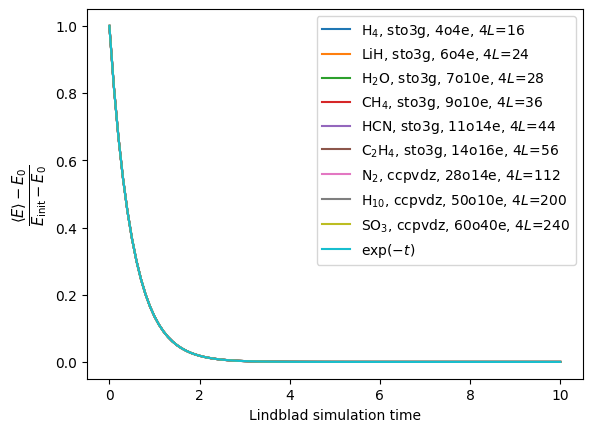

In [102]:
mlist = []
for idx in range(len(mol_list)):
    mol = mol_list[idx]
    print(f'{dub_list[idx]}, N_ao = {mol.nao}, N_ele = {mol.tot_electrons()}')
    n_qubits = int(2 * mol.nao)
    n_ele = int(mol.tot_electrons())
    e_nuc = mol.energy_nuc()
    mlist.append([mol.nao, n_ele])
    plt.plot(time, result[idx], label = dub_list[idx] + f', {mol.nao}o{n_ele}e, $4L$={2*n_qubits}')
    
pts_exp = np.linspace(0, 10, 101)
expt = np.exp(-2*pts_exp)

plt.plot(time, expt, label = '$\\exp(-t)$')
plt.legend()
plt.xlabel('Lindblad simulation time')
plt.ylabel('$\\frac{\\langle E\\rangle -E_{\\mathrm{0}}}{E_{\\mathrm{init}}-E_{\\mathrm{0}}}$', fontsize = 15)
plt.show()